In [349]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
!pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [350]:
df_ = pd.read_csv("Telco-Customer-Churn.csv")
df = df_

In [351]:
#Part 1

#Step 1
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.100,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.750,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.800,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.150,3487.95,No


In [352]:
df.shape

(7043, 21)

In [353]:
#Genel olarak incelendiğinde cinsiyete bağlı bir terk oranı gözükmemekte. Terk edenlerin bir bölümü yeni kullanıcılar olduğu
#gözlenmiştir. Müşterilerin bakmakla yükümlü olduğu kişiler terk etmemekte. Bu sayı gözlemlenen verinin küçük bir kısmı.
#Kontrat süreleri yıl bazlı olanların terk oranı düşük gözükmektedir. Diğer değişkenlere göre karar vermek zor gözükmektedir.

In [354]:
#Step 2
def grab_col_names(dataframe, cat_th=10,car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes=="O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique()<cat_th and dataframe[col].dtypes!="O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique()>cat_th and dataframe[col].dtypes=="O"]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    #num cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes!="O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [355]:
#Step 3
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 2
cat_but_car: 2
num_but_cat: 1


In [356]:
num_cols = [col for col in num_cols if "customerId" not in col]

In [357]:
# Değişkenleri inceledğimizde kategorik değişken sayısı 17, numerik değişken sayısı ise 4 tane olduğu gözlenmiştir.

In [358]:
#customerId yi drop edelim.
df = df.iloc[:,1:]

In [359]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

In [360]:
Emp_cols=['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
for col in Emp_cols:
    df[col]=df[col].replace("",np.nan)

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [362]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [364]:
#TotalCharges have 11 nan values.Let's see the complete data corresponding to these customers.

In [365]:
df[np.isnan(df["TotalCharges"])]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,NaN,No


In [366]:
# As we can see, tenure column is also has 0 entries. Let's see which tenure columns have 0 values.

In [367]:
df[df['tenure']==0].index

Int64Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [368]:
# Convert String values (Yes and No) of Churn column to 1 and 0
df.loc[df.Churn=='No','Churn'] = 0 
df.loc[df.Churn=='Yes','Churn'] = 1
#convert to integer .
df['Churn']=df['Churn'].astype('int32')

In [369]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 2


In [370]:
#Step 4

In [371]:
df.groupby("Churn")[num_cols].mean()

,tenure,MonthlyCharges,TotalCharges
Churn,,,
0,37.570,61.265,2555.344
1,17.979,74.441,1531.796


In [372]:
df.groupby(cat_cols).agg({"Churn":"mean"})

Churn
gender Partner Dependents PhoneService MultipleLines    InternetService OnlineSecurity      OnlineBackup        DeviceProtection    TechSupport         StreamingTV         StreamingMovies     Contract       PaperlessBilling PaymentMethod             SeniorCitizen Churn       
Female No      No         No           No phone service DSL             No                  No                  No                  No                  No                  No                  Month-to-month No               Bank transfer (automatic) 0             0      0.000
                                                                                                                                                                                                                                Credit card (automatic)   0             0      0.000
                                                                                                                                                                                                                                Electronic check          0             0      0.000
                                                                                                                                                                                                                                                                        1      1.000
                                                                                                                                                                                                                                                          1             1      1.000
                                                                                                                                                                                                                                Mailed check              0             0      0.000
                                                                                                                                                                                                                                                                        1      1.000
                                                                                                                                                                                                                                                          1             1      1.000
                                                                                                                                                                                                               Yes              Credit card (automatic)   0             1      1.000
                                                                                                                                                                                                                                Electronic check          0             1      1.000
                                                                                                                                                                                                                                                          1             1      1.000
                                                                                                                                                                                                                                Mailed check              0             0      0.000
                                                                                                                                                                                                                                                                        1      1.000
                                                                                                                    

In [373]:
#Step 5

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [374]:
for col in num_cols:    
    print(col, check_outlier(df,col))

tenure False
MonthlyCharges False
TotalCharges False


In [375]:
#Verinin yapısına fazla karışmamak adına değerleri yukarıda yazan şekilde belirlediğimizde aykırı değer gözükmemektedir.

In [376]:
#Step 6
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [377]:
#Eksik gözlem TotalCharges sütununda bulunmaktadır.

In [378]:
#Step 7

<AxesSubplot:>

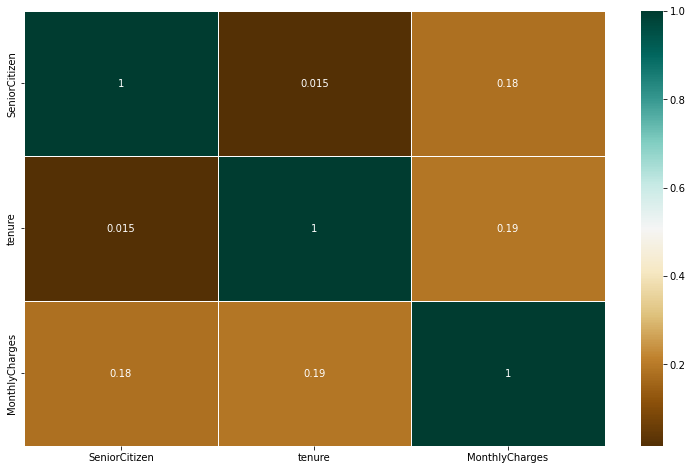

In [379]:
corr = df_.corr(method='kendall')
plt.figure(figsize=(13,8))
sns.heatmap(corr, annot=True, cmap="BrBG", linewidths=.9)

<AxesSubplot:>

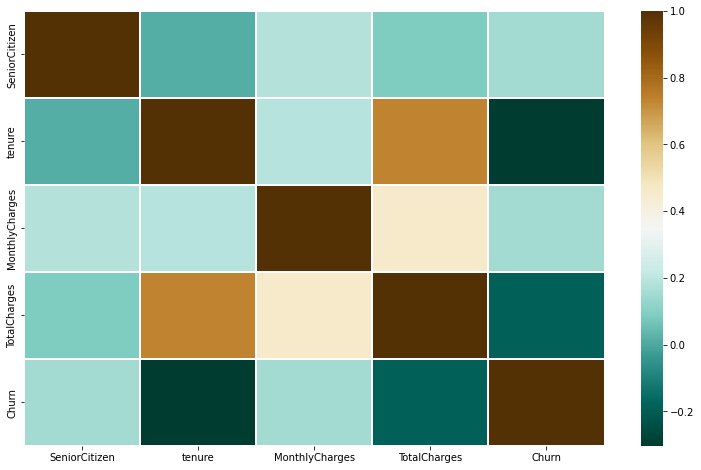

In [380]:
corr = df.corr(method='kendall')
plt.figure(figsize=(13,8))
sns.heatmap(corr, cmap="BrBG_r", linewidths=.4)

In [381]:
df.corr().unstack().sort_values()["Churn"]

tenure           -0.352
TotalCharges     -0.199
SeniorCitizen     0.151
MonthlyCharges    0.193
Churn             1.000
dtype: float64

In [382]:
#Korelasyon sonucunda Churn oranını en etkilemeyen aylık ödemeler, negatif yönde etkileyen ise tenure olarak gözlenmektedir.

In [383]:
#Part 2

In [384]:
#Step 1
#İlk görevde yapılan analizler özelinde veri de aykırı gözlem bulunmamıştır.

cat_cols, num_cols, cat_but_car = grab_col_names(df)
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

#knn ile eksik değerleri dolduralım
from sklearn.impute import KNNImputer

Observations: 7043
Variables: 20
cat_cols: 17
num_cols: 3
cat_but_car: 0
num_but_cat: 2


In [385]:
imputer = KNNImputer(n_neighbors=5)
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.850,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.500,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.150,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.750,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.650,1


In [386]:
#Step 2

In [387]:
def tenure(t):
    if t<=12:
        return 1
    elif t>12 and t<=24:
        return 2
    elif t>24 and t<=36:
        return 3
    elif t>36 and t<=48:
        return 4
    elif t>48 and t<=60:
        return 5
    else:
        return 6

df["new_tenure"]=df["tenure"].apply(lambda x: tenure(x))

In [388]:
df.loc[(df["Contract"] == 'Month-to-month'), 'New_Contract'] = 1
df.loc[(df["Contract"] == 'One year'), 'New_Contract'] = 2
df.loc[(df["Contract"] == 'Two year'), 'New_Contract'] = 3

df.loc[(df["PaymentMethod"] == 'Electronic check'), 'New_Payment'] = 1
df.loc[(df["PaymentMethod"] == 'Mailed check'), 'New_Payment'] = 2
df.loc[(df["PaymentMethod"] == 'Bank transfer (automatic)'), 'New_Payment'] = 3
df.loc[(df["PaymentMethod"] == 'Credit card (automatic)'), 'New_Payment'] = 4

In [389]:
df.drop(['MultipleLines', 'PhoneService',"tenure","Contract","PaymentMethod"], axis = 1, inplace = True)

In [390]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 18
cat_cols: 16
num_cols: 2
cat_but_car: 0
num_but_cat: 5


In [391]:
#Step 3


In [392]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

In [393]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    df = label_encoder(df, col)

In [394]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]


one_hot_encoder(df, ohe_cols).head()

df.head()

,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,new_tenure,New_Contract,New_Payment
0,0,0,1,0,DSL,No,Yes,No,No,No,No,1,29.850,29.850,0,1,1.000,1.000
1,1,0,0,0,DSL,Yes,No,Yes,No,No,No,0,56.950,1889.500,0,3,2.000,2.000
2,1,0,0,0,DSL,Yes,Yes,No,No,No,No,1,53.850,108.150,1,1,1.000,2.000
3,1,0,0,0,DSL,Yes,No,Yes,Yes,No,No,0,42.300,1840.750,0,4,2.000,3.000
4,0,0,0,0,Fiber optic,No,No,No,No,No,No,1,70.700,151.650,1,1,1.000,1.000


In [395]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 18
cat_cols: 16
num_cols: 2
cat_but_car: 0
num_but_cat: 9


In [396]:
#Step 4

for col in df.columns:
    df.replace("Yes",1,inplace=True)
    if col in cat_cols:
        df[col].replace("No",0,inplace=True)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

df.head()


,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,new_tenure,New_Contract,New_Payment
0,0,0,1,0,DSL,0,1,0,0,0,0,1,-1.160,-0.994,0,1,1.000,1.000
1,1,0,0,0,DSL,1,0,1,0,0,0,0,-0.260,-0.174,0,3,2.000,2.000
2,1,0,0,0,DSL,1,1,0,0,0,0,1,-0.363,-0.960,1,1,1.000,2.000
3,1,0,0,0,DSL,1,0,1,1,0,0,0,-0.747,-0.195,0,4,2.000,3.000
4,0,0,0,0,Fiber optic,0,0,0,0,0,0,1,0.197,-0.940,1,1,1.000,1.000


In [397]:
df.head(20)



,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,new_tenure,New_Contract,New_Payment
0,0,0,1,0,DSL,0,1,0,0,0,0,1,-1.160,-0.994,0,1,1.000,1.000
1,1,0,0,0,DSL,1,0,1,0,0,0,0,-0.260,-0.174,0,3,2.000,2.000
2,1,0,0,0,DSL,1,1,0,0,0,0,1,-0.363,-0.960,1,1,1.000,2.000
3,1,0,0,0,DSL,1,0,1,1,0,0,0,-0.747,-0.195,0,4,2.000,3.000
4,0,0,0,0,Fiber optic,0,0,0,0,0,0,1,0.197,-0.940,1,1,1.000,1.000
5,0,0,0,0,Fiber optic,0,0,1,0,1,1,1,1.160,-0.645,1,1,1.000,1.000
6,1,0,0,1,Fiber optic,0,1,0,0,1,0,1,0.809,-0.147,0,2,1.000,4.000
7,0,0,0,0,DSL,1,0,0,0,0,0,0,-1.164,-0.874,0,1,1.000,2.000
8,0,0,1,0,Fiber optic,0,0,1,1,1,1,1,1.331,0.337,1,3,1.000,1.000
9,1,0,0,1,DSL,1,1,0,0,0,0,0,-0.286,0.531,0,6,2.000,3.000


In [398]:
df.drop("InternetService",inplace=True,axis=1)

In [399]:
for col in df.columns:
    df[col]=df[col].replace("No internet service",np.nan)

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head(20)

,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,new_tenure,New_Contract,New_Payment
0,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,-1.160,-0.994,0.000,1.000,1.000,1.000
1,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,-0.260,-0.174,0.000,3.000,2.000,2.000
2,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,-0.363,-0.960,1.000,1.000,1.000,2.000
3,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,-0.747,-0.195,0.000,4.000,2.000,3.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.197,-0.940,1.000,1.000,1.000,1.000
5,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.160,-0.645,1.000,1.000,1.000,1.000
6,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.809,-0.147,0.000,2.000,1.000,4.000
7,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.164,-0.874,0.000,1.000,1.000,2.000
8,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.331,0.337,1.000,3.000,1.000,1.000
9,1.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,-0.286,0.531,0.000,6.000,2.000,3.000


In [401]:
#Step 5
y = df["Churn"]
X = df.drop(columns =["Churn"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7832465688594415